In [1]:
import pandas as pd
import numpy as np

# Data Preprocessing

In [2]:
industry_df = pd.read_csv("./data/업종거래소.csv", header = [0,1], index_col = 0)
industry_df = industry_df.xs('거래소 업종 (세부분류)', level=1, axis=1)
industry_df.dropna(how = 'all', inplace= True)
industry_df
financial_industries = [
    '금융',
    '코스피 금융업',
    '코스피 보험',
    '코스피 증권',
    '코스피 은행',
]

filter_df = industry_df.iloc[-1]
columns_to_remove = list(filter_df[filter_df.isin(financial_industries)].index)
#industry_df = industry_df.drop(columns=columns_to_remove)
price_df = pd.read_csv("./data/수정주가.csv", thousands= ',', index_col = 0)
price_df = price_df.drop(columns=columns_to_remove)
price_df.index = pd.to_datetime(price_df.index)
price_df.index.name = 'Date'
price_df

/var/folders/zp/5shvyfrd6js1krq6rr42d5mh0000gn/T/ipykernel_17589/538017060.py:1: DtypeWarning: Columns (1,3,4,6,7,9,10,12,13,15,16,18,19,21,22,24,25,27,28,30,31,33,34,36,37,39,40,42,43,45,46,48,49,51,52,54,55,57,58,60,63,64,66,67,69,70,72,73,75,76,78,79,81,82,84,85,87,88,90,91,93,94,96,97,99,100,102,103,105,106,108,109,111,112,114,115,117,118,120,121,123,124,126,127,129,130,132,133,135,136,138,139,141,142,144,145,147,148,150,151,153,154,156,157,159,160,162,163,165,166,168,169,171,172,174,175,177,178,180,181,183,184,186,187,189,190,192,193,195,196,198,199,201,202,204,205,207,208,210,211,213,214,216,217,219,220,222,223,225,226,228,229,231,232,234,235,237,238,240,241,243,244,246,247,249,250,252,253,255,256,258,259,261,262,264,265,267,268,270,271,273,274,276,277,279,280,282,283,285,286,288,289,291,292,294,295,297,298,300,301,303,304,306,307,309,310,312,313,315,316,318,319,321,322,324,325,327,328,330,333,334,336,337,339,340,342,343,345,346,348,349,351,352,354,355,357,358,360,361,363,364,366

,삼성전자,SK하이닉스,LG에너지솔루션,삼성바이오로직스,현대차,셀트리온,기아,POSCO홀딩스,NAVER,삼성SDI,...,에스앤씨엔진그룹,차이나하오란,웨이포트,성융광전투자,완리,평산차업 KDR,네프로아이티,중국고섬,SBI모기지,SNK
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-03,429,NaN,NaN,NaN,17203,NaN,199967,28303,NaN,21602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,434,NaN,NaN,NaN,17439,NaN,203091,28756,NaN,21697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,425,NaN,NaN,NaN,17085,NaN,199967,28484,NaN,20985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-06,426,NaN,NaN,NaN,17027,NaN,198405,28847,NaN,21127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,422,NaN,NaN,NaN,17262,NaN,201529,28938,NaN,21127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,76100,179600.0,378000.0,962000.0,249500,205000.0,102800,345000,170700.0,332000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-27,75800,175000.0,376500.0,973000.0,247500,200500.0,101800,346000,167900.0,338000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-28,76400,179300.0,368500.0,991000.0,259000,201500.0,104600,336500,163800.0,339500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
returns_df = price_df.pct_change(1)
returns_df

,삼성전자,SK하이닉스,LG에너지솔루션,삼성바이오로직스,현대차,셀트리온,기아,POSCO홀딩스,NAVER,삼성SDI,...,에스앤씨엔진그룹,차이나하오란,웨이포트,성융광전투자,완리,평산차업 KDR,네프로아이티,중국고섬,SBI모기지,SNK
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,0.011655,NaN,NaN,NaN,0.013719,NaN,0.015623,0.016005,NaN,0.004398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,-0.020737,NaN,NaN,NaN,-0.020299,NaN,-0.015382,-0.009459,NaN,-0.032816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-06,0.002353,NaN,NaN,NaN,-0.003395,NaN,-0.007811,0.012744,NaN,0.006767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,-0.009390,NaN,NaN,NaN,0.013802,NaN,0.015746,0.003155,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,-0.020592,-0.031806,0.052925,0.005225,-0.011881,0.012346,-0.011538,0.014706,0.035173,0.004539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-27,-0.003942,-0.025612,-0.003968,0.011435,-0.008016,-0.021951,-0.009728,0.002899,-0.016403,0.018072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-28,0.007916,0.024571,-0.021248,0.018499,0.046465,0.004988,0.027505,-0.027457,-0.024419,0.004438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
columns_to_remove

['KB금융',
 '신한지주',
 '삼성생명',
 '메리츠금융지주',
 '하나금융지주',
 '삼성화재',
 'LG',
 'HD한국조선해양',
 '우리금융지주',
 '기업은행',
 'SK',
 'SK스퀘어',
 '에코프로',
 '카카오뱅크',
 'DB손해보험',
 'HD현대',
 '미래에셋증권',
 '삼성카드',
 '한진칼',
 'NH투자증권',
 '삼성증권',
 'GS',
 '한국금융지주',
 'CJ',
 '키움증권',
 'LS',
 '카카오페이',
 'BNK금융지주',
 'JB금융지주',
 '현대해상',
 '두산',
 '롯데지주',
 '한화생명',
 '한미사이언스',
 '한국앤컴퍼니',
 '코리안리',
 'DGB금융지주',
 'OCI홀딩스',
 '신영증권',
 '영원무역홀딩스',
 '동원산업',
 '오리온홀딩스',
 '미래에셋생명',
 '동양생명',
 '쿠쿠홀딩스',
 '대신증권',
 '효성',
 '롯데손해보험',
 '현대지에프홀딩스',
 'LS에코에너지',
 '동아쏘시오홀딩스',
 '한화투자증권',
 '세아제강지주',
 'HDC',
 '한화손해보험',
 'SK디스커버리',
 '삼양홀딩스',
 '교보증권',
 '유안타증권',
 '하림지주',
 '우리기술투자',
 'LX홀딩스',
 'F&F홀딩스',
 '유진투자증권',
 '풍산홀딩스',
 '한국자산신탁',
 'SNT홀딩스',
 'HL홀딩스',
 'BGF',
 '스틱인베스트먼트',
 '농심홀딩스',
 '대상홀딩스',
 '부국증권',
 '현대차증권',
 '제주은행',
 '콜마홀딩스',
 '한국토지신탁',
 '미래에셋벤처투자',
 'DB금융투자',
 'SK증권',
 '동국홀딩스',
 '아주IB투자',
 '흥국화재',
 'JW홀딩스',
 '하이트진로홀딩스',
 '해성산업',
 '대덕',
 '한양증권',
 '미원홀딩스',
 '코오롱',
 '일진홀딩스',
 '다올투자증권',
 '경동인베스트',
 '유비쿼스홀딩스',
 '한국캐피탈',
 '비츠로테크',
 'AK홀딩스',
 '티와이홀딩스',
 '노루홀딩스',
 '서연',
 '

In [5]:
factor_df = pd.read_csv("./data/팩터모델.csv", index_col=0)
factor_df.index = pd.to_datetime(factor_df.index)
factor_df.index.name = 'Date'
factor_df = factor_df.rename(columns= dict(zip(factor_df.columns, ["HML", "SMB", "MOM", "MKT"])))
factor_df

,HML,SMB,MOM,MKT
Date,,,,
1990-01-03,NaN,NaN,NaN,-0.12
1990-01-04,NaN,NaN,NaN,2.23
1990-01-05,NaN,NaN,NaN,-1.48
1990-01-06,NaN,NaN,NaN,-0.25
1990-01-08,NaN,NaN,NaN,0.72
...,...,...,...,...
2024-08-26,0.02,-0.91,-0.92,-0.14
2024-08-27,-0.19,0.46,-0.35,-0.32
2024-08-28,-0.41,-0.50,0.98,0.02


In [7]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, gp
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import warnings
import copy  # deepcopy 사용을 위해 import

warnings.filterwarnings('ignore')

# 한글 폰트 설정 (필요 시 주석 해제)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

class GeneticProgrammingTrader:
    def __init__(self, price_df, factor_df, training_years=5, selection_years=5, out_sample_years=1, days_per_year=365):
        """
        초기화 메서드
        :param price_df: 주가 데이터 DataFrame
        :param factor_df: 팩터 데이터 DataFrame
        :param training_years: 학습 기간 (년)
        :param selection_years: 선택 기간 (년)
        :param out_sample_years: 외부 검증 기간 (년)
        :param days_per_year: 연도당 일수
        """
        self.price_df = price_df
        self.factor_df = factor_df
        self.training_years = training_years
        self.selection_years = selection_years
        self.out_sample_years = out_sample_years
        self.days_per_year = days_per_year
        self.setup_data()
        self.setup_gp()
    
    def setup_data(self):
        """
        데이터를 학습, 선택, 외부 검증 기간으로 분할
        """
        total_days = len(self.price_df)
        training_days = self.training_years * self.days_per_year
        selection_days = self.selection_years * self.days_per_year
        out_sample_days = self.out_sample_years * self.days_per_year
        
        if total_days < training_days + selection_days + out_sample_days:
            raise ValueError(f"데이터가 충분히 길지 않습니다. 최소 {self.training_years + self.selection_years + self.out_sample_years}년의 데이터가 필요합니다.")
        
        self.training_df = self.price_df.iloc[:training_days]
        self.selection_df = self.price_df.iloc[training_days:training_days + selection_days]
        self.out_sample_df = self.price_df.iloc[training_days + selection_days:training_days + selection_days + out_sample_days]
        
        self.training_factors = self.factor_df.iloc[:training_days]
        self.selection_factors = self.factor_df.iloc[training_days:training_days + selection_days]
        self.out_sample_factors = self.factor_df.iloc[training_days + selection_days:training_days + selection_days + out_sample_days]
        
        # 학습 및 선택 기간을 결합하여 GP 진화에 사용
        self.combined_price = pd.concat([self.training_df, self.selection_df])
        self.combined_factors = pd.concat([self.training_factors, self.selection_factors])
        
        # 외부 검증 데이터
        self.out_sample_price = self.out_sample_df['삼성전자']
        self.out_sample_factors = self.out_sample_factors
    
    def setup_gp(self):
        """
        GP 프리미티브 및 DEAP 툴박스 설정
        """
        # 루트 노드 전용 프리미티브 집합 정의
        self.root_pset = gp.PrimitiveSetTyped("ROOT", [pd.Series, int], pd.Series)
        self.root_pset.renameArguments(ARG0='price', ARG1='constant')
        
        # 루트 노드에만 사용할 오퍼레이터 정의
        def if_then_else(condition, then_expr, else_expr):
            return np.where(condition > 0, 1.0, 0.0)
        
        def and_op(a, b):
            return np.logical_and(a > 0, b > 0).astype(float)
        
        def or_op(a, b):
            return np.logical_or(a > 0, b > 0).astype(float)
        
        self.root_pset.addPrimitive(if_then_else, [pd.Series, pd.Series, pd.Series], pd.Series)
        self.root_pset.addPrimitive(and_op, [pd.Series, pd.Series], pd.Series)
        self.root_pset.addPrimitive(or_op, [pd.Series, pd.Series], pd.Series)
        
        # 내부 노드 전용 프리미티브 집합 정의 (조건 오퍼레이터 제외)
        self.inner_pset = gp.PrimitiveSetTyped("INNER", [pd.Series, int], pd.Series)
        self.inner_pset.renameArguments(ARG0='price', ARG1='constant')
        
        # Relational operators
        def greater_than(series, threshold):
            return (series > threshold).astype(float)
        
        def less_than(series, threshold):
            return (series < threshold).astype(float)
        
        self.inner_pset.addPrimitive(greater_than, [pd.Series, int], pd.Series)
        self.inner_pset.addPrimitive(less_than, [pd.Series, int], pd.Series)
        
        # Real functions
        def avg(series, days):
            return series.rolling(window=int(days)).mean()
        
        def max_func(series, days):
            return series.rolling(window=int(days)).max()
        
        def min_func(series, days):
            return series.rolling(window=int(days)).min()
        
        def median(series, days):
            return series.rolling(window=int(days)).median()
        
        def lag(series, days):
            return series.shift(int(days))
        
        def volatility(series, days):
            return series.rolling(window=int(days)).std()
        
        def rsi(series, period):
            delta = series.diff()
            up = delta.clip(lower=0)
            down = -1 * delta.clip(upper=0)
            gain = up.rolling(window=int(period)).mean()
            loss = down.rolling(window=int(period)).mean()
            RS = gain / loss
            RSI = 100 - (100 / (1 + RS))
            return RSI.fillna(0)
        
        self.inner_pset.addPrimitive(avg, [pd.Series, int], pd.Series)
        self.inner_pset.addPrimitive(max_func, [pd.Series, int], pd.Series)
        self.inner_pset.addPrimitive(min_func, [pd.Series, int], pd.Series)
        self.inner_pset.addPrimitive(median, [pd.Series, int], pd.Series)
        self.inner_pset.addPrimitive(lag, [pd.Series, int], pd.Series)
        self.inner_pset.addPrimitive(volatility, [pd.Series, int], pd.Series)
        self.inner_pset.addPrimitive(rsi, [pd.Series, int], pd.Series)
        
        # Real variables (Terminals)
        self.inner_pset.addTerminal(1.0, float)          # Days의 값 중 하나
        self.inner_pset.addTerminal(-1.0, float)         # Pr의 값 중 하나
        self.inner_pset.addTerminal(0.0, float)
        self.inner_pset.addTerminal(0.5, float)
        
        # Integer terminals
        self.inner_pset.addTerminal(0, int)
        self.inner_pset.addTerminal(1, int)
        self.inner_pset.addTerminal(2, int)
        self.inner_pset.addTerminal(3, int)
        self.inner_pset.addTerminal(5, int)
        self.inner_pset.addTerminal(10, int)
        
        # Float operators
        def float_add(a, b):
            return a + b
        
        def float_subtract(a, b):
            return a - b
        
        def float_multiply(a, b):
            return a * b
        
        def float_divide(a, b):
            return a / b if b != 0 else 1.0
        
        self.inner_pset.addPrimitive(float_add, [float, float], float)
        self.inner_pset.addPrimitive(float_subtract, [float, float], float)
        self.inner_pset.addPrimitive(float_multiply, [float, float], float)
        self.inner_pset.addPrimitive(float_divide, [float, float], float)
        
        # int 타입을 반환하는 간단한 프리미티브 함수 추가
        def identity_int(x):
            return x
        
        self.inner_pset.addPrimitive(identity_int, [int], int)
        
        # DEAP 설정
        creator.create('FitnessMax', base.Fitness, weights=(1.0,))
        creator.create('Individual', list, fitness=creator.FitnessMax)
        
        self.toolbox = base.Toolbox()
        
        # 개별 트리 생성기 등록
        self.toolbox.register('expr_root', gp.genFull, pset=self.root_pset, min_=1, max_=2)
        self.toolbox.register('expr_inner', gp.genHalfAndHalf, pset=self.inner_pset, min_=1, max_=3)
        
        # 커스텀 트리 생성 함수
        def create_individual():
            # 루트 노드 생성 (if_then_else, and_op, or_op 중 하나)
            root_tree = gp.PrimitiveTree(self.toolbox.expr_root())
            
            # 루트 노드의 각 자식 노드에 대해 내부 노드 생성
            # 여기서는 간단히, 내부 트리를 재귀적으로 생성하도록 함
            for node in root_tree:
                if isinstance(node, gp.Primitive):
                    for i in range(len(node.args)):
                        # Replace each argument with an inner subtree
                        subtree = gp.PrimitiveTree(self.toolbox.expr_inner())
                        node.args = tuple([subtree if idx == i else arg for idx, arg in enumerate(node.args)])
            
            # buy_expr와 sell_expr 생성
            buy_tree = gp.PrimitiveTree(self.toolbox.expr_root())
            self._expand_tree(buy_tree, self.inner_pset)
            
            sell_tree = gp.PrimitiveTree(self.toolbox.expr_root())
            self._expand_tree(sell_tree, self.inner_pset)
            
            return creator.Individual([buy_tree, sell_tree])
        
        # 트리 확장 함수
        def _expand_tree(self, tree, pset_inner):
            for node in tree:
                if isinstance(node, gp.Primitive):
                    for idx, arg in enumerate(node.args):
                        if isinstance(arg, gp.PrimitiveTree):
                            new_subtree = gp.PrimitiveTree(self.toolbox.expr_inner())
                            self._expand_tree(new_subtree, pset_inner)
                            node.args = tuple([new_subtree if i == idx else a for i, a in enumerate(node.args)])
        
        self.toolbox.register('individual', create_individual)
        self.toolbox.register('population', tools.initRepeat, list, self.toolbox.individual)
        
        self.toolbox.register('compile_buy', gp.compile, pset=self.root_pset)
        self.toolbox.register('compile_sell', gp.compile, pset=self.root_pset)
        self.toolbox.register('select', tools.selTournament, tournsize=3)
        
        # 'expr_mut'를 먼저 등록해야 합니다.
        self.toolbox.register('expr_mut', gp.genFull, pset=self.inner_pset, min_=0, max_=2)
        
        # 'mutate' 등록
        self.toolbox.register('mutate', gp.mutUniform, expr=self.toolbox.expr_mut, pset=self.inner_pset)
        
        # 'mate' 등록
        self.toolbox.register('mate', gp.cxOnePoint)
        
        # 교차 및 돌연변이 함수 수정
        def mate_individuals(ind1, ind2):
            # ind1과 ind2의 각 표현식은 이미 PrimitiveTree 객체임
            self.toolbox.mate(ind1[0], ind2[0])
            self.toolbox.mate(ind1[1], ind2[1])
            del ind1.fitness.values
            del ind2.fitness.values
            return ind1, ind2
        
        def mutate_individual(individual):
            self.toolbox.mutate(individual[0])
            self.toolbox.mutate(individual[1])
            del individual.fitness.values
            return individual,
        
        # toolbox에 커스텀 교차 및 돌연변이 등록
        self.toolbox.register('mate_custom', mate_individuals)
        self.toolbox.register('mutate_custom', mutate_individual)
        
        # 프리미티브 등록 상태 확인 (디버깅 용)
        print("Primitives by type (Root PSet):")
        for typ, prims in self.root_pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
        
        print("\nPrimitives by type (Inner PSet):")
        for typ, prims in self.inner_pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
    
    def _expand_tree(self, tree, pset_inner):
        """
        재귀적으로 트리를 확장하는 함수
        """
        for node in tree:
            if isinstance(node, gp.Primitive):
                for idx, arg in enumerate(node.args):
                    if isinstance(arg, gp.PrimitiveTree):
                        new_subtree = gp.PrimitiveTree(self.toolbox.expr_inner())
                        self._expand_tree(new_subtree, pset_inner)
                        node.args = tuple([new_subtree if i == idx else a for i, a in enumerate(node.args)])
    
    def evaluate_individual(self, individual, price_series, factor_df):
        """
        개체의 적합도를 평가하는 함수
        :param individual: 개체 (buy_expr, sell_expr)
        :param price_series: 주가 시리즈
        :param factor_df: 팩터 데이터프레임
        :return: 적합도 튜플
        """
        buy_expr, sell_expr = individual
        buy_func = self.toolbox.compile_buy(expr=buy_expr)
        sell_func = self.toolbox.compile_sell(expr=sell_expr)
        
        try:
            # 트리 내의 int 상수를 사용하도록 수정
            buy_signal = buy_func(price_series, 1)    # 정수 상수
            sell_signal = sell_func(price_series, -1) # 정수 상수
            
            # ensure buy_signal and sell_signal are pd.Series
            buy_signal = pd.Series(buy_signal, index=price_series.index) if isinstance(buy_signal, np.ndarray) else buy_signal
            sell_signal = pd.Series(sell_signal, index=price_series.index) if isinstance(sell_signal, np.ndarray) else sell_signal
            
            combined_signal = pd.Series(0, index=price_series.index)
            combined_signal[buy_signal > 0] = 1
            combined_signal[sell_signal > 0] = -1
            
            returns = price_series.pct_change().dropna()
            
            combined_signal = combined_signal.shift(1).dropna()
            returns = returns.loc[combined_signal.index]
            
            if len(combined_signal) != len(returns):
                raise ValueError(f"Signal length {len(combined_signal)} does not match returns length {len(returns)}.")
            
            strategy_returns = combined_signal * returns
        
            trading_cost = 0.001
            trades = combined_signal.diff().fillna(0) != 0
            strategy_returns[trades] -= trading_cost
        
            factors = factor_df.loc[strategy_returns.index]
            factors = factors.dropna()
        
            if factors.empty or strategy_returns.empty:
                raise ValueError("Either factors or strategy returns are empty after alignment.")
        
            strategy_returns = strategy_returns.loc[factors.index]
        
            X = factors[['MKT', 'SMB', 'HML', 'MOM']]
            y = strategy_returns - 0.02 / 252
            X = add_constant(X)
        
            model = OLS(y, X).fit()
            alpha = model.params['const']
            t_stat = model.tvalues['const']
            
            if t_stat > 2:
                return alpha,
            else:
                return -np.inf,
            
        except Exception as e:
            print(f"Exception occurred: {e}")
            return -np.inf,
    
    def run_evolution(self, population_size=500, generations=30, cxpb=0.7, mutpb=0.2):
        """
        유전 알고리즘을 실행하는 메서드
        :param population_size: 인구 크기
        :param generations: 세대 수
        :param cxpb: 교차 확률
        :param mutpb: 돌연변이 확률
        :return: 최종 인구
        """
        # 초기 인구 생성
        population = self.toolbox.population(n=population_size)
        
        print("유전 알고리즘을 시작합니다...")
        
        # 프리미티브 등록 상태 확인 (디버깅 용)
        print("Primitives by type (Root PSet):")
        for typ, prims in self.root_pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
        
        print("\nPrimitives by type (Inner PSet):")
        for typ, prims in self.inner_pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
        
        # 초기 개체의 적합도 평가
        for ind in population:
            ind.fitness.values = self.evaluate_individual(ind, self.combined_price['삼성전자'], self.combined_factors)
        
        # 진화 과정
        for gen in range(1, generations + 1):
            print(f"-- 세대 {gen} --")
            offspring = self.toolbox.select(population, len(population))
            offspring = list(map(copy.deepcopy, offspring))  # tools.clone 대신 copy.deepcopy 사용
        
            # Apply crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < cxpb:
                    self.toolbox.mate_custom(child1, child2)
        
            # Apply mutation
            for mutant in offspring:
                if random.random() < mutpb:
                    self.toolbox.mutate_custom(mutant)
        
            # Evaluate the individuals with invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            for ind in invalid_ind:
                ind.fitness.values = self.evaluate_individual(ind, self.combined_price['삼성전자'], self.combined_factors)
        
            population[:] = offspring
        
            # 상위 개체 출력
            top_ind = tools.selBest(population, 1)[0]
            buy_tree = top_ind[0]
            sell_tree = top_ind[1]
            print(f"최고의 개체 Buy Expression: {buy_tree}")
            print(f"최고의 개체 Sell Expression: {sell_tree}")
            print(f"적합도: {top_ind.fitness.values}")
        
        print("-- 최종 결과 --")
        best_ind = tools.selBest(population, 1)[0]
        buy_tree = best_ind[0]
        sell_tree = best_ind[1]
        print(f"최고의 개체 Buy Expression: {buy_tree}")
        print(f"최고의 개체 Sell Expression: {sell_tree}")
        print(f"적합도: {best_ind.fitness.values}")
        
        self.best_individual = best_ind
        return population
    
    def evaluate_out_of_sample(self):
        """
        외부 검증 기간을 사용하여 최고의 개체의 성과를 평가하고 시각화
        """
        if not hasattr(self, 'best_individual'):
            raise AttributeError("먼저 유전 알고리즘을 실행하여 최고 개체를 선택해야 합니다.")
        
        best_ind = self.best_individual
        buy_tree = best_ind[0]
        sell_tree = best_ind[1]
        
        # 최적의 거래 규칙 외부 검증
        buy_func = self.toolbox.compile_buy(expr=buy_tree)
        sell_func = self.toolbox.compile_sell(expr=sell_tree)
    
        buy_signal = buy_func(self.out_sample_price, 1)    # 정수 상수
        sell_signal = sell_func(self.out_sample_price, -1) # 정수 상수
    
        # ensure buy_signal and sell_signal are pd.Series
        buy_signal = pd.Series(buy_signal, index=self.out_sample_price.index) if isinstance(buy_signal, np.ndarray) else buy_signal
        sell_signal = pd.Series(sell_signal, index=self.out_sample_price.index) if isinstance(sell_signal, np.ndarray) else sell_signal
    
        # Buy/Sell 신호를 1, -1로 변환
        combined_signal = pd.Series(0, index=self.out_sample_price.index)
        combined_signal[buy_signal > 0] = 1
        combined_signal[sell_signal > 0] = -1
    
        # 다음날 수익률에 신호 적용
        returns = self.out_sample_price.pct_change().dropna()
        combined_signal = combined_signal.shift(1).dropna()
        returns = returns.loc[combined_signal.index]
    
        if len(combined_signal) != len(returns):
            raise ValueError(f"Signal length {len(combined_signal)} does not match returns length {len(returns)}.")
    
        strategy_returns = combined_signal * returns
    
        # 거래 비용 고려 (예: 0.1%)
        trading_cost = 0.001
        trades = combined_signal.diff().fillna(0) != 0
        strategy_returns[trades] -= trading_cost
    
        # 누적 시장 수익률 및 전략 수익률 시각화
        plt.figure(figsize=(12,6))
        plt.plot(self.out_sample_price.index, np.cumsum(self.out_sample_price.pct_change().fillna(0)), label='누적 시장 수익률')
        plt.plot(self.out_sample_price.index[:-1], np.cumsum(strategy_returns), label='누적 전략 수익률')
        plt.legend()
        plt.title('외부 검증 기간 동안의 전략 성과')
        plt.xlabel('날짜')
        plt.ylabel('누적 수익률')
        plt.show()
    
        # Buy/Sell 신호 시각화
        plt.figure(figsize=(12,6))
        plt.plot(self.out_sample_price.index, self.out_sample_price, label='가격')
        plt.scatter(buy_signal.index[buy_signal > 0], self.out_sample_price[buy_signal > 0], marker='^', color='g', label='Buy Signal', alpha=0.6)
        plt.scatter(sell_signal.index[sell_signal > 0], self.out_sample_price[sell_signal > 0], marker='v', color='r', label='Sell Signal', alpha=0.6)
        plt.legend()
        plt.title('외부 검증 기간 동안의 가격과 Buy/Sell 신호')
        plt.xlabel('날짜')
        plt.ylabel('가격')
        plt.show()
    
        # Buy/Sell 신호 표출
        print("Buy Signal 예시:")
        print(buy_signal[buy_signal > 0].head())
    
        print("Sell Signal 예시:")
        print(sell_signal[sell_signal > 0].head())
    
        # 전략 수익률 요약
        total_strategy_return = strategy_returns.sum()
        total_market_return = self.out_sample_price.pct_change().sum()
        print(f"외부 검증 기간 동안의 전략 총 수익률: {total_strategy_return:.4f}")
        print(f"외부 검증 기간 동안의 시장 총 수익률: {total_market_return:.4f}")
    
    def plot_primitives(self):
        """
        등록된 프리미티브를 출력하는 메서드
        """
        print("Primitives by type (Root PSet):")
        for typ, prims in self.root_pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
        
        print("\nPrimitives by type (Inner PSet):")
        for typ, prims in self.inner_pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
    
    def summarize_population(self, population, top=5):
        """
        현재 인구의 상위 개체들을 요약하는 메서드
        :param population: 인구 리스트
        :param top: 요약할 상위 개체 수
        """
        top_inds = tools.selBest(population, top)
        print(f"상위 {top} 개체:")
        for i, ind in enumerate(top_inds, 1):
            buy_tree = ind[0]
            sell_tree = ind[1]
            fitness = ind.fitness.values
            print(f"{i}. Buy: {buy_tree}, Sell: {sell_tree}, Fitness: {fitness}")

# 사용 예시
def main():
    # 1. 데이터 생성 및 분할
    # def generate_data():
    #     # 날짜 생성: 11년 (4018일 기준 약 11*365)
    #     dates = pd.date_range(start='2012-01-01', periods=4018, freq='D')  # 11년
    #     # 가격 데이터 생성: 무작위 누적합
    #     price_df = pd.DataFrame({
    #         '삼성전자': np.random.randn(len(dates)).cumsum() + 100  # 임의의 주가 데이터
    #     }, index=dates)
        
    #     # # 팩터 데이터 생성: 무작위 값
    #     # factor_df = pd.DataFrame({
    #     #     'MKT': np.random.randn(len(dates)),
    #     #     'SMB': np.random.randn(len(dates)),
    #     #     'HML': np.random.randn(len(dates)),
    #     #     'MOM': np.random.randn(len(dates))
    #     # }, index=dates)
        
    #     return price_df, factor_df
    
    # price_df, factor_df = generate_data()
    
    # 2. GeneticProgrammingTrader 클래스 인스턴스 생성
    gp_trader = GeneticProgrammingTrader(price_df, factor_df)
    
    # 3. 프리미티브 확인 (옵션)
    gp_trader.plot_primitives()
    
    # 4. 유전 알고리즘 실행
    population = gp_trader.run_evolution(population_size=500, generations=30, cxpb=0.7, mutpb=0.2)
    
    # 5. 상위 개체 요약 (옵션)
    gp_trader.summarize_population(population, top=5)
    
    # 6. 외부 검증 수행
    gp_trader.evaluate_out_of_sample()

if __name__ == "__main__":
    main()

Primitives by type (Root PSet):
Type <class 'pandas.core.series.Series'>: ['if_then_else', 'and_op', 'or_op']
Type <class 'int'>: []

Primitives by type (Inner PSet):
Type <class 'pandas.core.series.Series'>: ['greater_than', 'less_than', 'avg', 'max_func', 'min_func', 'median', 'lag', 'volatility', 'rsi']
Type <class 'int'>: ['identity_int']
Type <class 'float'>: ['float_add', 'float_subtract', 'float_multiply', 'float_divide']
Primitives by type (Root PSet):
Type <class 'pandas.core.series.Series'>: ['if_then_else', 'and_op', 'or_op']
Type <class 'int'>: []

Primitives by type (Inner PSet):
Type <class 'pandas.core.series.Series'>: ['greater_than', 'less_than', 'avg', 'max_func', 'min_func', 'median', 'lag', 'volatility', 'rsi']
Type <class 'int'>: ['identity_int']
Type <class 'float'>: ['float_add', 'float_subtract', 'float_multiply', 'float_divide']


TypeError: unhashable type: 'PrimitiveTree'

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, gp
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 3-2. 연산자 및 터미널 집합 정의 (타이핑된 GP 사용)
# 입력 타입: pd.Series, float; 출력 타입: pd.Series
pset = gp.PrimitiveSetTyped("MAIN", [pd.Series, float], pd.Series)
pset.renameArguments(ARG0='price', ARG1='constant')

# Level 1: Boolean operators and functions
def and_op(a, b):
    return np.logical_and(a > 0, b > 0).astype(float)

def or_op(a, b):
    return np.logical_or(a > 0, b > 0).astype(float)

pset.addPrimitive(and_op, [pd.Series, pd.Series], pd.Series)
pset.addPrimitive(or_op, [pd.Series, pd.Series], pd.Series)

# Level 2: Relational operators
def greater_than(series, threshold):
    return (series > threshold).astype(float)

def less_than(series, threshold):
    return (series < threshold).astype(float)

pset.addPrimitive(greater_than, [pd.Series, float], pd.Series)
pset.addPrimitive(less_than, [pd.Series, float], pd.Series)

# Level 3: Real functions
def avg(series, days):
    return series.rolling(window=int(days)).mean()

def max_func(series, days):
    return series.rolling(window=int(days)).max()

def min_func(series, days):
    return series.rolling(window=int(days)).min()

def median(series, days):
    return series.rolling(window=int(days)).median()

def lag(series, days):
    return series.shift(int(days))

def volatility(series, days):
    return series.rolling(window=int(days)).std()

def rsi(series, period):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    gain = up.rolling(window=int(period)).mean()
    loss = down.rolling(window=int(period)).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI.fillna(0)

pset.addPrimitive(avg, [pd.Series, float], pd.Series)
pset.addPrimitive(max_func, [pd.Series, float], pd.Series)
pset.addPrimitive(min_func, [pd.Series, float], pd.Series)
pset.addPrimitive(median, [pd.Series, float], pd.Series)
pset.addPrimitive(lag, [pd.Series, float], pd.Series)
pset.addPrimitive(volatility, [pd.Series, float], pd.Series)
pset.addPrimitive(rsi, [pd.Series, float], pd.Series)

# Level 4: Real variables (Terminals)
pset.addTerminal(1.0, float)          # Days의 값 중 하나
pset.addTerminal(-1.0, float)         # Pr의 값 중 하나
pset.addTerminal(0.0, float)
pset.addTerminal(0.5, float)

# Boolean terminals
pset.addTerminal(True, bool)
pset.addTerminal(False, bool)

# Ephemeral constants (무작위 float 생성)
pset.addEphemeralConstant("rand_float", lambda: random.uniform(-10, 10), float)

# 추가: float 연산자 등록 (이름 변경 후)
def float_add(a, b):
    return a + b

def float_subtract(a, b):
    return a - b

def float_multiply(a, b):
    return a * b

def float_divide(a, b):
    return a / b if b != 0 else 1.0

pset.addPrimitive(float_add, [float, float], float)
pset.addPrimitive(float_subtract, [float, float], float)
pset.addPrimitive(float_multiply, [float, float], float)
pset.addPrimitive(float_divide, [float, float], float)

# 프리미티브 등록 후 pset.primitives 출력
print("Primitives by type:")
for typ, prims in pset.primitives.items():
    prim_names = []
    for p in prims:
        if hasattr(p, 'name'):
            prim_names.append(p.name)
        elif hasattr(p, 'value'):
            prim_names.append(str(p.value))
        else:
            prim_names.append(str(p))
    print(f"Type {typ}: {prim_names}")

# 3-3. 적합도 함수 정의
def evaluate_individual(individual, price_series, factor_df):
    buy_expr, sell_expr = individual
    # 이미 individual의 각 요소는 PrimitiveTree 객체라고 가정
    buy_func = toolbox.compile(expr=buy_expr)
    sell_func = toolbox.compile(expr=sell_expr)
    
    try:
        # 트리 내의 float 상수를 사용하도록 float 연산자를 활용
        buy_signal = buy_func(price_series, 1.0)    # 예시 float 상수
        sell_signal = sell_func(price_series, -1.0) # 예시 float 상수
        
        # ensure buy_signal and sell_signal are pd.Series
        buy_signal = pd.Series(buy_signal, index=price_series.index) if isinstance(buy_signal, np.ndarray) else buy_signal
        sell_signal = pd.Series(sell_signal, index=price_series.index) if isinstance(sell_signal, np.ndarray) else sell_signal
        
        combined_signal = pd.Series(0, index=price_series.index)
        combined_signal[buy_signal > 0] = 1
        combined_signal[sell_signal > 0] = -1
        
        returns = price_series.pct_change().dropna()
        
        combined_signal = combined_signal.shift(1).dropna()
        returns = returns.loc[combined_signal.index]
        
        if len(combined_signal) != len(returns):
            raise ValueError(f"Signal length {len(combined_signal)} does not match returns length {len(returns)}.")
        
        strategy_returns = combined_signal * returns
    
        trading_cost = 0.001
        trades = combined_signal.diff().fillna(0) != 0
        strategy_returns[trades] -= trading_cost
    
        factors = factor_df.loc[strategy_returns.index]
        factors = factors.dropna()
    
        if factors.empty or strategy_returns.empty:
            raise ValueError("Either factors or strategy returns are empty after alignment.")
    
        strategy_returns = strategy_returns.loc[factors.index]
    
        X = factors[['MKT', 'SMB', 'HML', 'MOM']]
        y = strategy_returns - 0.02 / 252
        X = add_constant(X)
    
        model = OLS(y, X).fit()
        alpha = model.params['const']
        t_stat = model.tvalues['const']
        
        if t_stat > 2:
            return alpha,
        else:
            return -np.inf,
        
    except Exception as e:
        print(f"Exception occurred: {e}")
        return -np.inf,

# 3-4. DEAP 설정
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# 개별 트리 생성기 등록
toolbox.register('expr_buy', gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register('expr_sell', gp.genHalfAndHalf, pset=pset, min_=1, max_=3)

# 개별 생성 함수 등록
def create_individual():
    # 개체 내의 표현식을 PrimitiveTree로 변환하여 포함
    return creator.Individual([
        gp.PrimitiveTree(toolbox.expr_buy()),
        gp.PrimitiveTree(toolbox.expr_sell())
    ])

toolbox.register('individual', create_individual)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

toolbox.register('compile', gp.compile, pset=pset)
toolbox.register('select', tools.selTournament, tournsize=3)

# 'expr_mut'를 먼저 등록해야 합니다.
toolbox.register('expr_mut', gp.genFull, pset=pset, min_=0, max_=2)

# 'mutate' 등록
toolbox.register('mutate', gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# 'mate' 등록
toolbox.register('mate', gp.cxOnePoint)

# 교차 및 돌연변이 함수 수정
def mate_individuals(ind1, ind2):
    # ind1과 ind2의 각 표현식은 이미 PrimitiveTree 객체임
    toolbox.mate(ind1[0], ind2[0])
    toolbox.mate(ind1[1], ind2[1])
    del ind1.fitness.values
    del ind2.fitness.values
    return ind1, ind2

def mutate_individual(individual):
    toolbox.mutate(individual[0])
    toolbox.mutate(individual[1])
    del individual.fitness.values
    return individual,

# toolbox에 커스텀 교차 및 돌연변이 등록
toolbox.register('mate_custom', mate_individuals)
toolbox.register('mutate_custom', mutate_individual)

# 4. 유전 알고리즘 실행
def main():
    # 실제 데이터 사용
    # 이미 존재하는 price_df와 factor_df 사용 (예: price_df의 '삼성전자')
    # 예시로 price_df와 factor_df가 전역 변수로 존재한다고 가정
    
    global price_series, factor_df
    
    price_series = price_df['삼성전자']
    # factor_df는 이미 정의되어 있다고 가정
    
    random.seed(42)
    population = toolbox.population(n=10)
    NGEN = 10
    CXPB = 0.5
    MUTPB = 0.2

    print("유전 알고리즘을 시작합니다...")

    # 프리미티브 등록 상태 확인
    print("Primitives by type:")
    for typ, prims in pset.primitives.items():
        prim_names = []
        for p in prims:
            if hasattr(p, 'name'):
                prim_names.append(p.name)
            elif hasattr(p, 'value'):
                prim_names.append(str(p.value))
            else:
                prim_names.append(str(p))
        print(f"Type {typ}: {prim_names}")

    # 초기 개체의 적합도 평가
    for ind in population:
        ind.fitness.values = evaluate_individual(ind, price_series, factor_df)
    
    for gen in range(1, NGEN + 1):
        print(f"-- 세대 {gen} --")
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate_custom(child1, child2)

        # Apply mutation
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate_custom(mutant)

        # Evaluate the individuals with invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalid_ind:
            ind.fitness.values = evaluate_individual(ind, price_series, factor_df)

        population[:] = offspring

        top_ind = tools.selBest(population, 1)[0]
        print(f"최고의 개체: {str(top_ind)}, 적합도: {top_ind.fitness.values}")
    
    print("-- 최종 결과 --")
    best_ind = tools.selBest(population, 1)[0]
    print(f"최고의 개체: {str(best_ind)}, 적합도: {best_ind.fitness.values}")

if __name__ == "__main__":
    main()

Primitives by type:
Type <class 'pandas.core.series.Series'>: ['and_op', 'or_op', 'greater_than', 'less_than', 'avg', 'max_func', 'min_func', 'median', 'lag', 'volatility', 'rsi']
Type <class 'float'>: ['float_add', 'float_subtract', 'float_multiply', 'float_divide']
Type <class 'bool'>: []
유전 알고리즘을 시작합니다...
Primitives by type:
Type <class 'pandas.core.series.Series'>: ['and_op', 'or_op', 'greater_than', 'less_than', 'avg', 'max_func', 'min_func', 'median', 'lag', 'volatility', 'rsi']
Type <class 'float'>: ['float_add', 'float_subtract', 'float_multiply', 'float_divide']
Type <class 'bool'>: []
Exception occurred: window must be an integer 0 or greater
Exception occurred: window must be an integer 0 or greater
Exception occurred: window must be an integer 0 or greater
Exception occurred: window must be an integer 0 or greater
Exception occurred: window must be an integer 0 or greater
-- 세대 1 --
Exception occurred: window must be an integer 0 or greater
Exception occurred: window must b

Primitives by type after setup_gp:
Type <class 'pandas.core.series.Series'>: ['and_op', 'or_op', 'greater_than', 'less_than', 'avg', 'max_func', 'min_func', 'median', 'lag', 'volatility', 'rsi']
Type <class 'int'>: ['identity_int']
Type <class 'float'>: []
Primitives by type:
Type <class 'pandas.core.series.Series'>: ['and_op', 'or_op', 'greater_than', 'less_than', 'avg', 'max_func', 'min_func', 'median', 'lag', 'volatility', 'rsi']
Type <class 'int'>: ['identity_int']
Type <class 'float'>: []
유전 알고리즘을 시작합니다...
Primitives by type during run_evolution:
Type <class 'pandas.core.series.Series'>: ['and_op', 'or_op', 'greater_than', 'less_than', 'avg', 'max_func', 'min_func', 'median', 'lag', 'volatility', 'rsi']
Type <class 'int'>: ['identity_int']
Type <class 'float'>: []
<function <lambda> at 0x176a7ac00>
<function <lambda> at 0x176a7ad40>
<function <lambda> at 0x176a7ad40>
<function <lambda> at 0x176a7ac00>
<function <lambda> at 0x176a7ac00>
<function <lambda> at 0x176a7ad40>
<function 

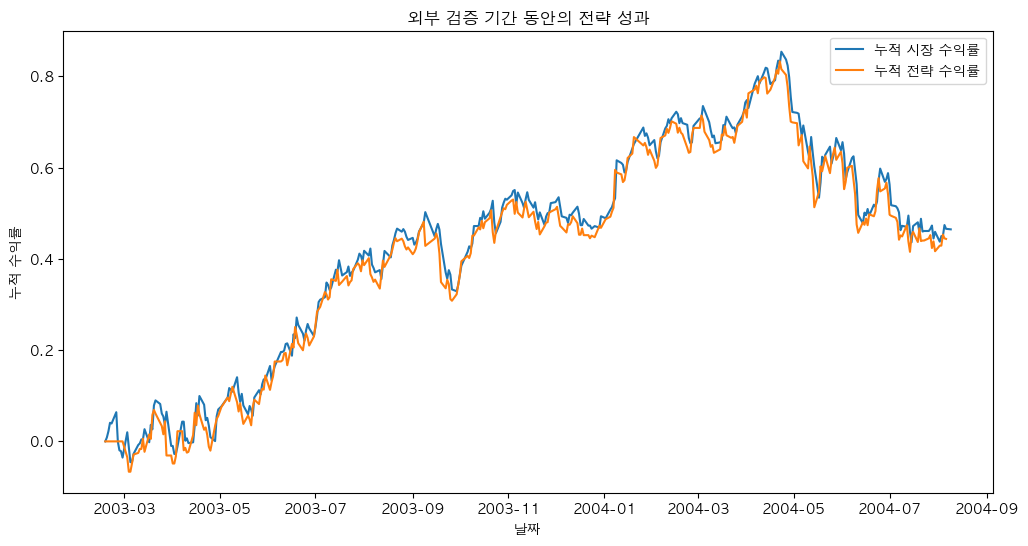

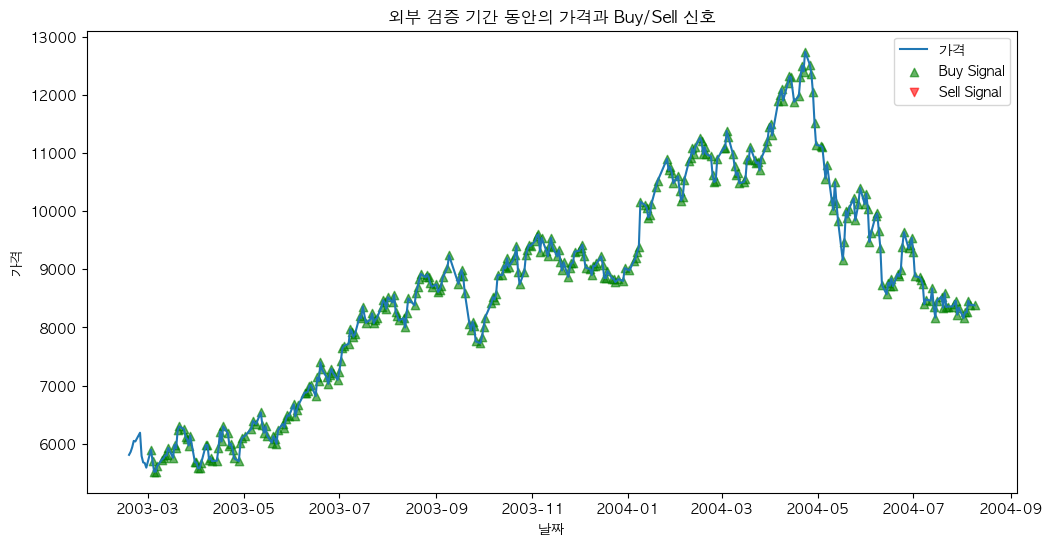

Buy Signal 예시:
Date
2003-03-03    53.435115
2003-03-04    44.520548
2003-03-05    36.538462
2003-03-06    31.724138
2003-03-07    36.363636
Name: 삼성전자, dtype: float64
Sell Signal 예시:
Series([], Name: 삼성전자, dtype: float64)
외부 검증 기간 동안의 전략 총 수익률: 0.4436
외부 검증 기간 동안의 시장 총 수익률: 0.4646


In [56]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, gp
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import warnings
import copy  # 추가: deepcopy 사용을 위해 import

warnings.filterwarnings('ignore')

# 한글 폰트 설정 (필요 시 주석 해제)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

class GeneticProgrammingTrader:
    def __init__(self, price_df, factor_df, training_years=5, selection_years=5, out_sample_years=1, days_per_year=365):
        """
        초기화 메서드
        :param price_df: 주가 데이터 DataFrame
        :param factor_df: 팩터 데이터 DataFrame
        :param training_years: 학습 기간 (년)
        :param selection_years: 선택 기간 (년)
        :param out_sample_years: 외부 검증 기간 (년)
        :param days_per_year: 연도당 일수
        """
        self.price_df = price_df
        self.factor_df = factor_df
        self.training_years = training_years
        self.selection_years = selection_years
        self.out_sample_years = out_sample_years
        self.days_per_year = days_per_year
        self.setup_data()
        self.setup_gp()
    
    def setup_data(self):
        """
        데이터를 학습, 선택, 외부 검증 기간으로 분할
        """
        total_days = len(self.price_df)
        training_days = self.training_years * self.days_per_year
        selection_days = self.selection_years * self.days_per_year
        out_sample_days = self.out_sample_years * self.days_per_year
        
        if total_days < training_days + selection_days + out_sample_days:
            raise ValueError(f"데이터가 충분히 길지 않습니다. 최소 {self.training_years + self.selection_years + self.out_sample_years}년의 데이터가 필요합니다.")
        
        self.training_df = self.price_df.iloc[:training_days]
        self.selection_df = self.price_df.iloc[training_days:training_days + selection_days]
        self.out_sample_df = self.price_df.iloc[training_days + selection_days:training_days + selection_days + out_sample_days]
        
        self.training_factors = self.factor_df.iloc[:training_days]
        self.selection_factors = self.factor_df.iloc[training_days:training_days + selection_days]
        self.out_sample_factors = self.factor_df.iloc[training_days + selection_days:training_days + selection_days + out_sample_days]
        #self.out_sample_factors = self.factor_df.iloc[training_days + selection_days:training_days + selection_days + out_sample_days]  # 수정
        
        # 학습 및 선택 기간을 결합하여 GP 진화에 사용
        self.combined_price = pd.concat([self.training_df, self.selection_df])
        self.combined_factors = pd.concat([self.training_factors, self.selection_factors])
        
        # 외부 검증 데이터
        self.out_sample_price = self.out_sample_df['삼성전자']
        self.out_sample_factors = self.out_sample_factors
    
    def setup_gp(self):
        """
        GP 프리미티브 및 DEAP 툴박스 설정
        """
        # 3-2. 연산자 및 터미널 집합 정의 (타이핑된 GP 사용)
        # 입력 타입: pd.Series, int; 출력 타입: pd.Series
        self.pset = gp.PrimitiveSetTyped("MAIN", [pd.Series, int], pd.Series)
        self.pset.renameArguments(ARG0='price', ARG1='constant')
        
        # Level 1: Boolean operators and functions
        def if_then_else(condition, out1, out2):
            return pd.Series(np.where(condition > 0, out1, out2), index=condition.index)        
        
        def and_op(a, b):
            return np.logical_and(a > 0, b > 0).astype(float)
        
        def or_op(a, b):
            return np.logical_or(a > 0, b > 0).astype(float)
        
        self.pset.addPrimitive(and_op, [pd.Series, pd.Series], pd.Series)
        self.pset.addPrimitive(or_op, [pd.Series, pd.Series], pd.Series)
        
        # Level 2: Relational operators
        def greater_than(series, threshold):
            return (series > threshold).astype(float)
        
        def less_than(series, threshold):
            return (series < threshold).astype(float)
        
        self.pset.addPrimitive(greater_than, [pd.Series, int], pd.Series)
        self.pset.addPrimitive(less_than, [pd.Series, int], pd.Series)
        
        # Level 3: Real functions
        def avg(series, days):
            return series.rolling(window=int(days)).mean()
        
        def max_func(series, days):
            return series.rolling(window=int(days)).max()
        
        def min_func(series, days):
            return series.rolling(window=int(days)).min()
        
        def median(series, days):
            return series.rolling(window=int(days)).median()
        
        def lag(series, days):
            return series.shift(int(days))
        
        def volatility(series, days):
            return series.rolling(window=int(days)).std()
        
        def rsi(series, period):
            delta = series.diff()
            up = delta.clip(lower=0)
            down = -1 * delta.clip(upper=0)
            gain = up.rolling(window=int(period)).mean()
            loss = down.rolling(window=int(period)).mean()
            RS = gain / loss
            RSI = 100 - (100 / (1 + RS))
            return RSI.fillna(0)
        
        self.pset.addPrimitive(avg, [pd.Series, int], pd.Series)
        self.pset.addPrimitive(max_func, [pd.Series, int], pd.Series)
        self.pset.addPrimitive(min_func, [pd.Series, int], pd.Series)
        self.pset.addPrimitive(median, [pd.Series, int], pd.Series)
        self.pset.addPrimitive(lag, [pd.Series, int], pd.Series)
        self.pset.addPrimitive(volatility, [pd.Series, int], pd.Series)
        self.pset.addPrimitive(rsi, [pd.Series, int], pd.Series)
        
        # Level 4: Real variables (Terminals)
        self.pset.addTerminal(1.0, float)          # Days의 값 중 하나
        self.pset.addTerminal(-1.0, float)         # Pr의 값 중 하나
        self.pset.addTerminal(0.0, float)
        self.pset.addTerminal(0.5, float)
        
        # Integer terminals
        self.pset.addTerminal(0, int)
        self.pset.addTerminal(1, int)
        self.pset.addTerminal(2, int)
        self.pset.addTerminal(3, int)
        self.pset.addTerminal(5, int)
        self.pset.addTerminal(10, int)
        
        # Boolean terminals
        # self.pset.addTerminal(True, bool)
        # self.pset.addTerminal(False, bool)
        
        # Ephemeral constants (무작위 float 생성)
        #self.pset.addEphemeralConstant("rand_float", lambda: random.uniform(-10, 10), float)
        
        # 추가: float 연산자 등록 (이름 변경 후)
        # def float_add(a, b):
        #     return a + b
        
        # def float_subtract(a, b):
        #     return a - b
        
        # def float_multiply(a, b):
        #     return a * b
        
        # def float_divide(a, b):
        #     return a / b if b != 0 else 1.0
        
        # self.pset.addPrimitive(float_add, [float, float], float)
        # self.pset.addPrimitive(float_subtract, [float, float], float)
        # self.pset.addPrimitive(float_multiply, [float, float], float)
        # self.pset.addPrimitive(float_divide, [float, float], float)
        
        # **추가: int 타입을 반환하는 간단한 프리미티브 함수 추가**
        def identity_int(x):
            return x
        
        self.pset.addPrimitive(identity_int, [int], int)
        
        # DEAP 설정
        creator.create('FitnessMax', base.Fitness, weights=(1.0,))
        creator.create('Individual', list, fitness=creator.FitnessMax)
        
        self.toolbox = base.Toolbox()
        
        # 개별 트리 생성기 등록
        self.toolbox.register('expr_buy', gp.genHalfAndHalf, pset=self.pset, min_=1, max_=3)
        self.toolbox.register('expr_sell', gp.genHalfAndHalf, pset=self.pset, min_=1, max_=3)
        
        # 개별 생성 함수 등록
        def create_individual():
            # 개체 내의 표현식을 PrimitiveTree로 변환하여 포함
            return creator.Individual([
                gp.PrimitiveTree(self.toolbox.expr_buy()),
                gp.PrimitiveTree(self.toolbox.expr_sell())
            ])
        
        self.toolbox.register('individual', create_individual)
        self.toolbox.register('population', tools.initRepeat, list, self.toolbox.individual)
        
        self.toolbox.register('compile', gp.compile, pset=self.pset)
        self.toolbox.register('select', tools.selTournament, tournsize=3)
        
        # 'expr_mut'를 먼저 등록해야 합니다.
        self.toolbox.register('expr_mut', gp.genFull, pset=self.pset, min_=0, max_=2)
        
        # 'mutate' 등록
        self.toolbox.register('mutate', gp.mutUniform, expr=self.toolbox.expr_mut, pset=self.pset)
        
        # 'mate' 등록
        self.toolbox.register('mate', gp.cxOnePoint)
        
        # 교차 및 돌연변이 함수 수정
        def mate_individuals(ind1, ind2):
            # ind1과 ind2의 각 표현식은 이미 PrimitiveTree 객체임
            self.toolbox.mate(ind1[0], ind2[0])
            self.toolbox.mate(ind1[1], ind2[1])
            del ind1.fitness.values
            del ind2.fitness.values
            return ind1, ind2
        
        def mutate_individual(individual):
            self.toolbox.mutate(individual[0])
            self.toolbox.mutate(individual[1])
            del individual.fitness.values
            return individual,
        
        # toolbox에 커스텀 교차 및 돌연변이 등록
        self.toolbox.register('mate_custom', mate_individuals)
        self.toolbox.register('mutate_custom', mutate_individual)
        
        # **프리미티브 등록 상태 확인 (디버깅 용)**
        print("Primitives by type after setup_gp:")
        for typ, prims in self.pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
    
    def evaluate_individual(self, individual, price_series, factor_df):
        """
        개체의 적합도를 평가하는 함수
        :param individual: 개체 (buy_expr, sell_expr)
        :param price_series: 주가 시리즈
        :param factor_df: 팩터 데이터프레임
        :return: 적합도 튜플
        """
        buy_expr, sell_expr = individual
        buy_func = self.toolbox.compile(expr=buy_expr)
        sell_func = self.toolbox.compile(expr=sell_expr)
        print(buy_func)
        print(sell_func)
        try:
            # 트리 내의 int 상수를 사용하도록 수정
            buy_signal = buy_func(price_series, 1)
            sell_signal = sell_func(price_series, -1)  # 원래는 -1 사용
            
            # ensure buy_signal and sell_signal are pd.Series
            buy_signal = pd.Series(buy_signal, index=price_series.index) if isinstance(buy_signal, np.ndarray) else buy_signal
            sell_signal = pd.Series(sell_signal, index=price_series.index) if isinstance(sell_signal, np.ndarray) else sell_signal
            
            # **수정된 combined_signal 설정**
            combined_signal = pd.Series(0, index=price_series.index)
            
            # buy_signal이 양수이고 sell_signal이 양수가 아닌 경우에 1
            buy_only = (buy_signal > 0) & (sell_signal <= 0)
            combined_signal[buy_only] = 1
            
            # sell_signal이 양수이고 buy_signal이 양수가 아닌 경우에 -1
            sell_only = (sell_signal > 0) & (buy_signal <= 0)
            combined_signal[sell_only] = -1
            
            # 그 외의 경우는 이미 0으로 설정되어 있음
            
            returns = price_series.pct_change().dropna()
            
            combined_signal = combined_signal.shift(1).dropna()
            returns = returns.loc[combined_signal.index]
            
            if len(combined_signal) != len(returns):
                raise ValueError(f"Signal length {len(combined_signal)} does not match returns length {len(returns)}.")
            
            strategy_returns = combined_signal * returns
        
            trading_cost = 0.001
            trades = combined_signal.diff().fillna(0) != 0
            strategy_returns[trades] -= trading_cost
        
            factors = factor_df.loc[strategy_returns.index]
            factors = factors.dropna()
        
            if factors.empty or strategy_returns.empty:
                raise ValueError("Either factors or strategy returns are empty after alignment.")
        
            strategy_returns = strategy_returns.loc[factors.index]
        
            X = factors[['MKT', 'SMB', 'HML', 'MOM']]
            y = strategy_returns - 0.02 / 252
            X = add_constant(X)
        
            model = OLS(y, X).fit()
            alpha = model.params['const']
            t_stat = model.tvalues['const']
            
            if t_stat > 2:
                return alpha,
            else:
                return -np.inf,
            
        except Exception as e:
            print(f"Exception occurred: {e}, buy expression: {buy_expr}, sell expression: {sell_expr}")
            return -np.inf,
    
    def run_evolution(self, population_size=500, generations=30, cxpb=0.7, mutpb=0.2):
        """
        유전 알고리즘을 실행하는 메서드
        :param population_size: 인구 크기
        :param generations: 세대 수
        :param cxpb: 교차 확률
        :param mutpb: 돌연변이 확률
        :return: 최종 인구
        """
        # 초기 인구 생성
        population = self.toolbox.population(n=population_size)
        
        print("유전 알고리즘을 시작합니다...")
        
        # 프리미티브 등록 상태 확인 (디버깅 용)
        print("Primitives by type during run_evolution:")
        for typ, prims in self.pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
        
        # 초기 개체의 적합도 평가
        for ind in population:
            ind.fitness.values = self.evaluate_individual(ind, self.combined_price['삼성전자'], self.combined_factors)
        
        # 진화 과정
        for gen in range(1, generations + 1):
            print(f"-- 세대 {gen} --")
            offspring = self.toolbox.select(population, len(population))
            offspring = list(map(copy.deepcopy, offspring))  # tools.clone 대신 copy.deepcopy 사용
        
            # Apply crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < cxpb:
                    self.toolbox.mate_custom(child1, child2)
        
            # Apply mutation
            for mutant in offspring:
                if random.random() < mutpb:
                    self.toolbox.mutate_custom(mutant)
        
            # Evaluate the individuals with invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            for ind in invalid_ind:
                ind.fitness.values = self.evaluate_individual(ind, self.combined_price['삼성전자'], self.combined_factors)
        
            population[:] = offspring
        
            # 상위 개체 출력
            top_ind = tools.selBest(population, 1)[0]
            buy_tree = top_ind[0]
            sell_tree = top_ind[1]
            print(f"최고의 개체 Buy Expression: {buy_tree}")
            print(f"최고의 개체 Sell Expression: {sell_tree}")
            print(f"적합도: {top_ind.fitness.values}")
        
        print("-- 최종 결과 --")
        best_ind = tools.selBest(population, 1)[0]
        buy_tree = best_ind[0]
        sell_tree = best_ind[1]
        print(f"최고의 개체 Buy Expression: {buy_tree}")
        print(f"최고의 개체 Sell Expression: {sell_tree}")
        print(f"적합도: {best_ind.fitness.values}")
        
        self.best_individual = best_ind
        return population
    
    def evaluate_out_of_sample(self):
        """
        외부 검증 기간을 사용하여 최고의 개체의 성과를 평가하고 시각화
        """
        if not hasattr(self, 'best_individual'):
            raise AttributeError("먼저 유전 알고리즘을 실행하여 최고 개체를 선택해야 합니다.")
        
        best_ind = self.best_individual
        buy_tree = best_ind[0]
        sell_tree = best_ind[1]
        
        # 최적의 거래 규칙 외부 검증
        buy_func = self.toolbox.compile(expr=buy_tree)
        sell_func = self.toolbox.compile(expr=sell_tree)
    
        buy_signal = buy_func(self.out_sample_price, 1)    # 정수 상수
        sell_signal = sell_func(self.out_sample_price, -1) # 정수 상수
    
        # ensure buy_signal and sell_signal are pd.Series
        buy_signal = pd.Series(buy_signal, index=self.out_sample_price.index) if isinstance(buy_signal, np.ndarray) else buy_signal
        sell_signal = pd.Series(sell_signal, index=self.out_sample_price.index) if isinstance(sell_signal, np.ndarray) else sell_signal
    
        # **수정된 combined_signal 설정**
        combined_signal = pd.Series(0, index=self.out_sample_price.index)
        
        # buy_signal이 양수이고 sell_signal이 양수가 아닌 경우에 1
        buy_only = (buy_signal > 0) & (sell_signal <= 0)
        combined_signal[buy_only] = 1
        
        # sell_signal이 양수이고 buy_signal이 양수가 아닌 경우에 -1
        sell_only = (sell_signal > 0) & (buy_signal <= 0)
        combined_signal[sell_only] = -1
        
        # 그 외의 경우는 이미 0으로 설정되어 있음
    
        # 다음날 수익률에 신호 적용
        returns = self.out_sample_price.pct_change().dropna()
        combined_signal = combined_signal.shift(1).dropna()
        returns = returns.loc[combined_signal.index]
    
        if len(combined_signal) != len(returns):
            raise ValueError(f"Signal length {len(combined_signal)} does not match returns length {len(returns)}.")
    
        strategy_returns = combined_signal * returns
    
        # 거래 비용 고려 (예: 0.1%)
        trading_cost = 0.001
        trades = combined_signal.diff().fillna(0) != 0
        strategy_returns[trades] -= trading_cost
    
        # 누적 시장 수익률 및 전략 수익률 시각화
        plt.figure(figsize=(12,6))
        plt.plot(self.out_sample_price.index, np.cumsum(self.out_sample_price.pct_change().fillna(0)), label='누적 시장 수익률')
        plt.plot(self.out_sample_price.index[:-1], np.cumsum(strategy_returns), label='누적 전략 수익률')
        plt.legend()
        plt.title('외부 검증 기간 동안의 전략 성과')
        plt.xlabel('날짜')
        plt.ylabel('누적 수익률')
        plt.show()
    
        # Buy/Sell 신호 시각화
        plt.figure(figsize=(12,6))
        plt.plot(self.out_sample_price.index, self.out_sample_price, label='가격')
        plt.scatter(buy_signal.index[buy_signal > 0], self.out_sample_price[buy_signal > 0], marker='^', color='g', label='Buy Signal', alpha=0.6)
        plt.scatter(sell_signal.index[sell_signal > 0], self.out_sample_price[sell_signal > 0], marker='v', color='r', label='Sell Signal', alpha=0.6)
        plt.legend()
        plt.title('외부 검증 기간 동안의 가격과 Buy/Sell 신호')
        plt.xlabel('날짜')
        plt.ylabel('가격')
        plt.show()
    
        # Buy/Sell 신호 표출
        print("Buy Signal 예시:")
        print(buy_signal[buy_signal > 0].head())
    
        print("Sell Signal 예시:")
        print(sell_signal[sell_signal > 0].head())
    
        # 전략 수익률 요약
        total_strategy_return = strategy_returns.sum()
        total_market_return = self.out_sample_price.pct_change().sum()
        print(f"외부 검증 기간 동안의 전략 총 수익률: {total_strategy_return:.4f}")
        print(f"외부 검증 기간 동안의 시장 총 수익률: {total_market_return:.4f}")
    
    def plot_primitives(self):
        """
        등록된 프리미티브를 출력하는 메서드
        """
        print("Primitives by type:")
        for typ, prims in self.pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
    
    def summarize_population(self, population, top=5):
        """
        현재 인구의 상위 개체들을 요약하는 메서드
        :param population: 인구 리스트
        :param top: 요약할 상위 개체 수
        """
        top_inds = tools.selBest(population, top)
        print(f"상위 {top} 개체:")
        for i, ind in enumerate(top_inds, 1):
            buy_tree = ind[0]
            sell_tree = ind[1]
            fitness = ind.fitness.values
            print(f"{i}. Buy: {buy_tree}, Sell: {sell_tree}, Fitness: {fitness}")

# 사용 예시
def main():
    
    # 2. GeneticProgrammingTrader 클래스 인스턴스 생성
    gp_trader = GeneticProgrammingTrader(price_df, factor_df)
    
    # 3. 프리미티브 확인 (옵션)
    gp_trader.plot_primitives()
    
    # 4. 유전 알고리즘 실행
    population = gp_trader.run_evolution(population_size=50, generations=5, cxpb=0.7, mutpb=0.2)
    
    # 5. 상위 개체 요약 (옵션)
    gp_trader.summarize_population(population, top=5)
    
    # 6. 외부 검증 수행
    gp_trader.evaluate_out_of_sample()

if __name__ == "__main__":
    main()

Primitives by type after setup_gp:
Type <class 'pandas.core.series.Series'>: ['if_then_else', 'and_op', 'or_op', 'greater_than', 'less_than', 'Avg', 'Max', 'Min', 'Median', 'Lag', 'Volatility', 'RSI']
Type <class 'int'>: ['get_int_constant']
Primitives by type:
Type <class 'pandas.core.series.Series'>: ['if_then_else', 'and_op', 'or_op', 'greater_than', 'less_than', 'Avg', 'Max', 'Min', 'Median', 'Lag', 'Volatility', 'RSI']
Type <class 'int'>: ['get_int_constant']
유전 알고리즘을 시작합니다...
Primitives by type during run_evolution:
Type <class 'pandas.core.series.Series'>: ['if_then_else', 'and_op', 'or_op', 'greater_than', 'less_than', 'Avg', 'Max', 'Min', 'Median', 'Lag', 'Volatility', 'RSI']
Type <class 'int'>: ['get_int_constant']
Buy expression: if_then_else(greater_than(Volatility(price, 66), Lag(price, 99)))
Sell expression: if_then_else(greater_than(Lag(price, 82), Min(price, 12)))
Buy expression: or_op(less_than(Volatility(price, 20), Avg(price, 59)), less_than(RSI(price, 86), Lag(price

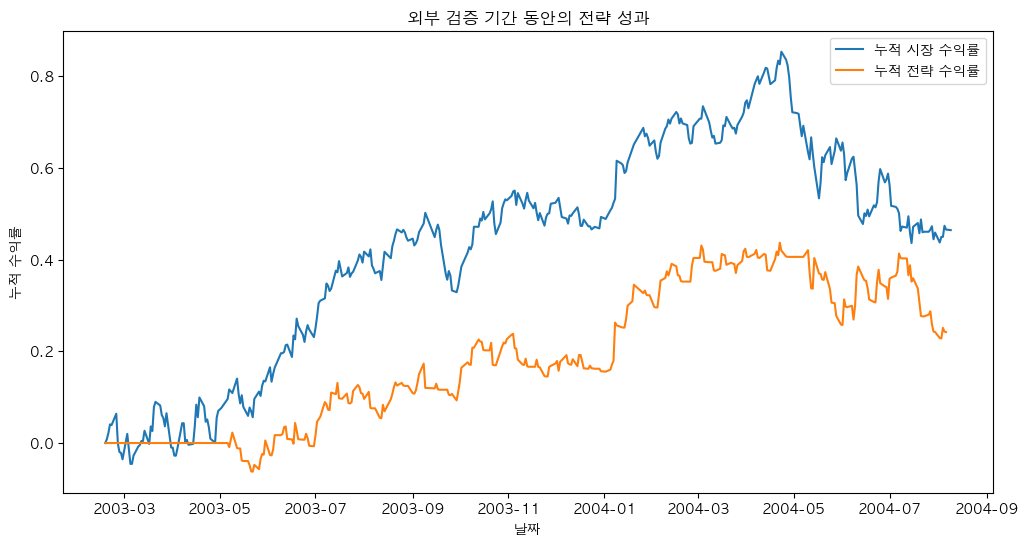

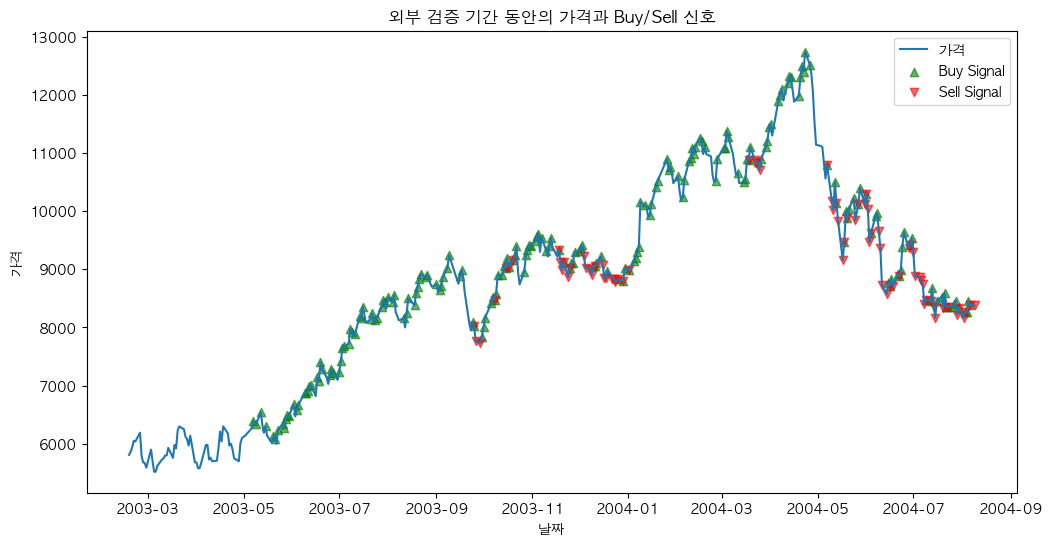

Buy Signal 예시:
Date
2003-05-07    1.0
2003-05-09    1.0
2003-05-12    1.0
2003-05-15    1.0
2003-05-20    1.0
Name: 삼성전자, dtype: float64
Sell Signal 예시:
Date
2003-09-25    1.0
2003-09-26    1.0
2003-09-29    1.0
2003-10-08    1.0
2003-10-15    1.0
Name: 삼성전자, dtype: float64
외부 검증 기간 동안의 전략 총 수익률: 0.2420
외부 검증 기간 동안의 시장 총 수익률: 0.4646


In [77]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, gp
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import warnings
import copy  # 추가: deepcopy 사용을 위해 import

warnings.filterwarnings('ignore')

# 한글 폰트 설정 (필요 시 주석 해제)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

class GeneticProgrammingTrader:
    def __init__(self, price_df, factor_df, training_years=5, selection_years=5, out_sample_years=1, days_per_year=365):
        """
        초기화 메서드
        :param price_df: 주가 데이터 DataFrame
        :param factor_df: 팩터 데이터 DataFrame
        :param training_years: 학습 기간 (년)
        :param selection_years: 선택 기간 (년)
        :param out_sample_years: 외부 검증 기간 (년)
        :param days_per_year: 연도당 일수
        """
        self.price_df = price_df
        self.factor_df = factor_df
        self.training_years = training_years
        self.selection_years = selection_years
        self.out_sample_years = out_sample_years
        self.days_per_year = days_per_year
        self.setup_data()
        self.setup_gp()
    
    def setup_data(self):
        """
        데이터를 학습, 선택, 외부 검증 기간으로 분할
        """
        total_days = len(self.price_df)
        training_days = self.training_years * self.days_per_year
        selection_days = self.selection_years * self.days_per_year
        out_sample_days = self.out_sample_years * self.days_per_year
        
        if total_days < training_days + selection_days + out_sample_days:
            raise ValueError(f"데이터가 충분히 길지 않습니다. 최소 {self.training_years + self.selection_years + self.out_sample_years}년의 데이터가 필요합니다.")
        
        self.training_df = self.price_df.iloc[:training_days]
        self.selection_df = self.price_df.iloc[training_days:training_days + selection_days]
        self.out_sample_df = self.price_df.iloc[training_days + selection_days:training_days + selection_days + out_sample_days]
        
        self.training_factors = self.factor_df.iloc[:training_days]
        self.selection_factors = self.factor_df.iloc[training_days:training_days + selection_days]
        self.out_sample_factors = self.factor_df.iloc[training_days + selection_days:training_days + selection_days + out_sample_days]
        #self.out_sample_factors = self.factor_df.iloc[training_days + selection_days:training_days + selection_days + out_sample_days]  # 수정
        
        # 학습 및 선택 기간을 결합하여 GP 진화에 사용
        self.combined_price = pd.concat([self.training_df, self.selection_df])
        self.combined_factors = pd.concat([self.training_factors, self.selection_factors])
        
        # 외부 검증 데이터
        self.out_sample_price = self.out_sample_df['삼성전자']
        self.out_sample_factors = self.out_sample_factors
    
    def setup_gp(self):
        """
        GP 프리미티브 및 DEAP 툴박스 설정
        """
        # 3-2. 연산자 및 터미널 집합 정의 (타이핑된 GP 사용)
        # 입력 타입: pd.Series, int; 출력 타입: pd.Series
        self.pset = gp.PrimitiveSetTyped("MAIN", [pd.Series], pd.Series)
        self.pset.renameArguments(ARG0='price')
        
        # Level 1: Boolean operators and functions
        def if_then_else(condition):
            return pd.Series(np.where(condition > 0, 1, 0), index=condition.index)

        def and_op(a, b):
            return pd.Series(np.logical_and(a > 0, b > 0).astype(float), index=a.index)
        
        def or_op(a, b):
            return pd.Series(np.logical_or(a > 0, b > 0).astype(float), index=a.index)

        self.pset.addPrimitive(if_then_else, [pd.Series], pd.Series, name="if_then_else")
        self.pset.addPrimitive(and_op, [pd.Series, pd.Series], pd.Series, name="and_op")
        self.pset.addPrimitive(or_op, [pd.Series, pd.Series], pd.Series, name="or_op")
        
        # Level 2: Relational operators
        def greater_than(series1, series2):
            return pd.Series((series1 > series2).astype(float), index=series1.index)
        
        def less_than(series1, series2):
            return pd.Series((series1 < series2).astype(float), index=series1.index)
        
        self.pset.addPrimitive(greater_than, [pd.Series, pd.Series], pd.Series, name="greater_than")
        self.pset.addPrimitive(less_than, [pd.Series, pd.Series], pd.Series, name="less_than")
        
        # Level 3: Real functions
        def avg(series, days):
            return series.rolling(window=int(days)).mean()
        
        def max_func(series, days):
            return series.rolling(window=int(days)).max()
        
        def min_func(series, days):
            return series.rolling(window=int(days)).min()
        
        def median(series, days):
            return series.rolling(window=int(days)).median()
        
        def lag(series, days):
            return series.shift(int(days))
        
        def volatility(series, days):
            return series.rolling(window=int(days)).std()
        
        def rsi(series, period):
            delta = series.diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
            rs = gain / loss
            return 100 - (100 / (1 + rs))
        
        self.pset.addPrimitive(avg, [pd.Series, int], pd.Series, name="Avg")
        self.pset.addPrimitive(max_func, [pd.Series, int], pd.Series, name="Max")
        self.pset.addPrimitive(min_func, [pd.Series, int], pd.Series, name="Min")
        self.pset.addPrimitive(median, [pd.Series, int], pd.Series, name="Median")
        self.pset.addPrimitive(lag, [pd.Series, int], pd.Series, name="Lag")
        self.pset.addPrimitive(volatility, [pd.Series, int], pd.Series, name="Volatility")
        self.pset.addPrimitive(rsi, [pd.Series, int], pd.Series, name="RSI")
        
        # # Level 4: Real variables (Terminals)
        # self.pset.addTerminal(1.0, float)          # Days의 값 중 하나
        # self.pset.addTerminal(-1.0, float)         # Pr의 값 중 하나
        # self.pset.addTerminal(0.0, float)
        # self.pset.addTerminal(0.5, float)
        
        # # Integer terminals
        # self.pset.addTerminal(0, int)
        # self.pset.addTerminal(1, int)
        # self.pset.addTerminal(2, int)
        # self.pset.addTerminal(3, int)
        # self.pset.addTerminal(5, int)
        # self.pset.addTerminal(10, int)
        # Level 4: Terminals
        for i in range(1, 101):
            self.pset.addTerminal(i, int)
        #self.pset.addTerminal('price', pd.Series) # price 제거
                
        # # **추가: int 타입을 반환하는 간단한 프리미티브 함수 추가**
        # def identity_int(x):
        #     return x
        
        # self.pset.addPrimitive(identity_int, [int], int)
        self.pset.addEphemeralConstant("rand_int", lambda: random.uniform(1, 100), int)
        def get_int_constant():
            return random.randint(1, 100)

        self.pset.addPrimitive(get_int_constant, [], int, name="get_int_constant")        
        # DEAP 설정
        creator.create('FitnessMax', base.Fitness, weights=(1.0,))
        creator.create('Individual', list, fitness=creator.FitnessMax)
        
        self.toolbox = base.Toolbox()
        def generate_tree():
            # 루트 노드 프리미티브만 선택
            root_primitives = [p for p in self.pset.primitives[pd.Series] if p.name in ["if_then_else", "and_op", "or_op"]]
            #root_primitives = [p for p in self.pset.primitives[pd.Series] if p.name in ["if_then_else"]]#, "and", "or"]]
            root = random.choice(root_primitives)
            if root.name == "if_then_else":
                # arity=1
                return [root] + generate_subtree(2, is_comparison=True)
            else:
                # arity=2
                return [root] + generate_subtree(2, is_comparison=True) + generate_subtree(2, is_comparison=True)

        def generate_subtree(level, is_comparison=False):
            if level == 2 or is_comparison:
                # 비교 연산자 프리미티브 선택
                comp_primitives = [p for p in self.pset.primitives[pd.Series] if p.name in ["greater_than", "less_than"]]
                if not comp_primitives:
                    raise ValueError("No comparison primitives available.")
                comp = random.choice(comp_primitives)
                # arity=2 (series, float)
                return [comp] + generate_subtree(3, is_comparison=False) + generate_subtree(3, is_comparison=False)   # is_comparison=False to prevent infinite recursion
            elif level == 3:
                # 실수 함수 프리미티브 선택
                func_primitives = [p for p in self.pset.primitives[pd.Series] if p.name in ["Avg", "Max", "Min", "Median", "Lag", "Volatility", "RSI"]]
                if not func_primitives:
                    raise ValueError("No function primitives available.")
                func = random.choice(func_primitives)
                # arity=2 (series, int)
                return [func] + generate_subtree(5) + generate_subtree(4)
            elif level == 4:
                # 터미널: 정수 상수만
                return [gp.Terminal(random.randint(1, 100), int, int)]
            elif level == 5:
                # 터미널: series만 price or returns
                return [gp.Terminal('price', pd.Series, pd.Series)]
                #return [gp.Terminal(self.pset.terminals[pd.Series][0], pd.Series, pd.Series)]
            else:
                raise ValueError(f"Invalid level: {level}")
                    
                    
        # 개별 트리 생성기 등록
        self.toolbox.register('expr_buy', generate_tree)#, pset=self.pset, min_=1, max_=3)
        self.toolbox.register('expr_sell', generate_tree)#, pset=self.pset, min_=1, max_=3)
        
        # 개별 생성 함수 등록
        # def create_individual():
        #     # 개체 내의 표현식을 PrimitiveTree로 변환하여 포함
        #     return creator.Individual([
        #         gp.PrimitiveTree(self.toolbox.expr_buy()),
        #         gp.PrimitiveTree(self.toolbox.expr_sell())
        #     ])

        def create_individual():
            buy_expr = self.toolbox.expr_buy()
            sell_expr = self.toolbox.expr_sell()
            
            # buy_expr과 sell_expr이 이미 PrimitiveTree인지 확인
            if not isinstance(buy_expr, gp.PrimitiveTree):
                buy_expr = gp.PrimitiveTree(buy_expr)
            if not isinstance(sell_expr, gp.PrimitiveTree):
                sell_expr = gp.PrimitiveTree(sell_expr)
            
            return creator.Individual([buy_expr, sell_expr])        
        self.toolbox.register('individual', create_individual)
        self.toolbox.register('population', tools.initRepeat, list, self.toolbox.individual)
        
        self.toolbox.register('compile', gp.compile, pset=self.pset)
        self.toolbox.register('select', tools.selTournament, tournsize=3)
        
        # 'expr_mut'를 먼저 등록해야 합니다.
        self.toolbox.register('expr_mut', gp.genFull, pset=self.pset, min_=0, max_=2)
        
        # 'mutate' 등록
        self.toolbox.register('mutate', gp.mutUniform, expr=self.toolbox.expr_mut, pset=self.pset)
        
        # 'mate' 등록
        self.toolbox.register('mate', gp.cxOnePoint)
        
        # 교차 및 돌연변이 함수 수정
        def mate_individuals(ind1, ind2):
            # ind1과 ind2의 각 표현식은 이미 PrimitiveTree 객체임
            self.toolbox.mate(ind1[0], ind2[0])
            self.toolbox.mate(ind1[1], ind2[1])
            del ind1.fitness.values
            del ind2.fitness.values
            return ind1, ind2
        
        def mutate_individual(individual):
            self.toolbox.mutate(individual[0])
            self.toolbox.mutate(individual[1])
            del individual.fitness.values
            return individual,
        
        # toolbox에 커스텀 교차 및 돌연변이 등록
        self.toolbox.register('mate_custom', mate_individuals)
        self.toolbox.register('mutate_custom', mutate_individual)
        
        # **프리미티브 등록 상태 확인 (디버깅 용)**
        print("Primitives by type after setup_gp:")
        for typ, prims in self.pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
    
    def evaluate_individual(self, individual, price_series, factor_df):
        """
        개체의 적합도를 평가하는 함수
        :param individual: 개체 (buy_expr, sell_expr)
        :param price_series: 주가 시리즈
        :param factor_df: 팩터 데이터프레임
        :return: 적합도 튜플
        """
        buy_expr, sell_expr = individual
        # 디버깅을 위한 출력
        #print("Individual:", individual)
        print("Buy expression:", buy_expr)
        print("Sell expression:", sell_expr)
        buy_func = self.toolbox.compile(expr=buy_expr)
        sell_func = self.toolbox.compile(expr=sell_expr)
        
        try:
            # 트리 내의 int 상수를 사용하도록 수정
            buy_signal = buy_func(price_series)
            sell_signal = sell_func(price_series)
            
            # ensure buy_signal and sell_signal are pd.Series
            buy_signal = pd.Series(buy_signal, index=price_series.index) if isinstance(buy_signal, np.ndarray) else buy_signal
            sell_signal = pd.Series(sell_signal, index=price_series.index) if isinstance(sell_signal, np.ndarray) else sell_signal
            
            # **수정된 combined_signal 설정**
            combined_signal = pd.Series(0, index=price_series.index)
            
            # buy_signal이 양수이고 sell_signal이 양수가 아닌 경우에 1
            buy_only = (buy_signal > 0) & (sell_signal <= 0)
            combined_signal[buy_only] = 1
            
            # sell_signal이 양수이고 buy_signal이 양수가 아닌 경우에 -1
            sell_only = (sell_signal > 0) & (buy_signal <= 0)
            combined_signal[sell_only] = -1
            
            # 그 외의 경우는 이미 0으로 설정되어 있음
            
            returns = price_series.pct_change().dropna()
            
            combined_signal = combined_signal.shift(1).dropna()
            returns = returns.loc[combined_signal.index]
            
            if len(combined_signal) != len(returns):
                raise ValueError(f"Signal length {len(combined_signal)} does not match returns length {len(returns)}.")
            
            strategy_returns = combined_signal * returns
        
            trading_cost = 0.001
            trades = combined_signal.diff().fillna(0) != 0
            strategy_returns[trades] -= trading_cost
        
            factors = factor_df.loc[strategy_returns.index]
            factors = factors.dropna()
        
            if factors.empty or strategy_returns.empty:
                raise ValueError("Either factors or strategy returns are empty after alignment.")
        
            strategy_returns = strategy_returns.loc[factors.index]
        
            X = factors[['MKT', 'SMB', 'HML', 'MOM']]
            y = strategy_returns - 0.02 / 252
            X = add_constant(X)
        
            model = OLS(y, X).fit()
            alpha = model.params['const']
            t_stat = model.tvalues['const']
            
            if t_stat > 2:
                return alpha,
            else:
                return -np.inf,
            
        except Exception as e:
            print(f"Exception occurred: {e}, buy expression: {buy_expr}, sell expression: {sell_expr}")
            return -np.inf,
    
    def run_evolution(self, population_size=500, generations=30, cxpb=0.7, mutpb=0.2):
        """
        유전 알고리즘을 실행하는 메서드
        :param population_size: 인구 크기
        :param generations: 세대 수
        :param cxpb: 교차 확률
        :param mutpb: 돌연변이 확률
        :return: 최종 인구
        """
        # 초기 인구 생성
        population = self.toolbox.population(n=population_size)
        #print(population)
        print("유전 알고리즘을 시작합니다...")
        
        # 프리미티브 등록 상태 확인 (디버깅 용)
        print("Primitives by type during run_evolution:")
        for typ, prims in self.pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
        
        # 초기 개체의 적합도 평가
        for ind in population:
            ind.fitness.values = self.evaluate_individual(ind, self.combined_price['삼성전자'], self.combined_factors)
        
        # 진화 과정
        for gen in range(1, generations + 1):
            print(f"-- 세대 {gen} --")
            offspring = self.toolbox.select(population, len(population))
            offspring = list(map(copy.deepcopy, offspring))  # tools.clone 대신 copy.deepcopy 사용
        
            # Apply crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < cxpb:
                    self.toolbox.mate_custom(child1, child2)
        
            # Apply mutation
            for mutant in offspring:
                if random.random() < mutpb:
                    self.toolbox.mutate_custom(mutant)
        
            # Evaluate the individuals with invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            for ind in invalid_ind:
                ind.fitness.values = self.evaluate_individual(ind, self.combined_price['삼성전자'], self.combined_factors)
        
            population[:] = offspring
        
            # 상위 개체 출력
            top_ind = tools.selBest(population, 1)[0]
            buy_tree = top_ind[0]
            sell_tree = top_ind[1]
            print(f"최고의 개체 Buy Expression: {buy_tree}")
            print(f"최고의 개체 Sell Expression: {sell_tree}")
            print(f"적합도: {top_ind.fitness.values}")
        
        print("-- 최종 결과 --")
        best_ind = tools.selBest(population, 1)[0]
        buy_tree = best_ind[0]
        sell_tree = best_ind[1]
        print(f"최고의 개체 Buy Expression: {buy_tree}")
        print(f"최고의 개체 Sell Expression: {sell_tree}")
        print(f"적합도: {best_ind.fitness.values}")
        
        self.best_individual = best_ind
        return population
    
    def evaluate_out_of_sample(self):
        """
        외부 검증 기간을 사용하여 최고의 개체의 성과를 평가하고 시각화
        """
        if not hasattr(self, 'best_individual'):
            raise AttributeError("먼저 유전 알고리즘을 실행하여 최고 개체를 선택해야 합니다.")
        
        best_ind = self.best_individual
        buy_tree = best_ind[0]
        sell_tree = best_ind[1]
        
        # 최적의 거래 규칙 외부 검증
        buy_func = self.toolbox.compile(expr=buy_tree)
        sell_func = self.toolbox.compile(expr=sell_tree)
    
        buy_signal = buy_func(self.out_sample_price)    
        sell_signal = sell_func(self.out_sample_price) 
    
        # ensure buy_signal and sell_signal are pd.Series
        buy_signal = pd.Series(buy_signal, index=self.out_sample_price.index) if isinstance(buy_signal, np.ndarray) else buy_signal
        sell_signal = pd.Series(sell_signal, index=self.out_sample_price.index) if isinstance(sell_signal, np.ndarray) else sell_signal
    
        # **수정된 combined_signal 설정**
        combined_signal = pd.Series(0, index=self.out_sample_price.index)
        
        # buy_signal이 양수이고 sell_signal이 양수가 아닌 경우에 1
        buy_only = (buy_signal > 0) & (sell_signal <= 0)
        combined_signal[buy_only] = 1
        
        # sell_signal이 양수이고 buy_signal이 양수가 아닌 경우에 -1
        sell_only = (sell_signal > 0) & (buy_signal <= 0)
        combined_signal[sell_only] = -1
        
        # 그 외의 경우는 이미 0으로 설정되어 있음
    
        # 다음날 수익률에 신호 적용
        returns = self.out_sample_price.pct_change().dropna()
        combined_signal = combined_signal.shift(1).dropna()
        returns = returns.loc[combined_signal.index]
    
        if len(combined_signal) != len(returns):
            raise ValueError(f"Signal length {len(combined_signal)} does not match returns length {len(returns)}.")
    
        strategy_returns = combined_signal * returns
    
        # 거래 비용 고려 (예: 0.1%)
        trading_cost = 0.001
        trades = combined_signal.diff().fillna(0) != 0
        strategy_returns[trades] -= trading_cost
    
        # 누적 시장 수익률 및 전략 수익률 시각화
        plt.figure(figsize=(12,6))
        plt.plot(self.out_sample_price.index, np.cumsum(self.out_sample_price.pct_change().fillna(0)), label='누적 시장 수익률')
        plt.plot(self.out_sample_price.index[:-1], np.cumsum(strategy_returns), label='누적 전략 수익률')
        plt.legend()
        plt.title('외부 검증 기간 동안의 전략 성과')
        plt.xlabel('날짜')
        plt.ylabel('누적 수익률')
        plt.show()
    
        # Buy/Sell 신호 시각화
        plt.figure(figsize=(12,6))
        plt.plot(self.out_sample_price.index, self.out_sample_price, label='가격')
        plt.scatter(buy_signal.index[buy_signal > 0], self.out_sample_price[buy_signal > 0], marker='^', color='g', label='Buy Signal', alpha=0.6)
        plt.scatter(sell_signal.index[sell_signal > 0], self.out_sample_price[sell_signal > 0], marker='v', color='r', label='Sell Signal', alpha=0.6)
        plt.legend()
        plt.title('외부 검증 기간 동안의 가격과 Buy/Sell 신호')
        plt.xlabel('날짜')
        plt.ylabel('가격')
        plt.show()
    
        # Buy/Sell 신호 표출
        print("Buy Signal 예시:")
        print(buy_signal[buy_signal > 0].head())
    
        print("Sell Signal 예시:")
        print(sell_signal[sell_signal > 0].head())
    
        # 전략 수익률 요약
        total_strategy_return = strategy_returns.sum()
        total_market_return = self.out_sample_price.pct_change().sum()
        print(f"외부 검증 기간 동안의 전략 총 수익률: {total_strategy_return:.4f}")
        print(f"외부 검증 기간 동안의 시장 총 수익률: {total_market_return:.4f}")
    
    def plot_primitives(self):
        """
        등록된 프리미티브를 출력하는 메서드
        """
        print("Primitives by type:")
        for typ, prims in self.pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
    
    def summarize_population(self, population, top=5):
        """
        현재 인구의 상위 개체들을 요약하는 메서드
        :param population: 인구 리스트
        :param top: 요약할 상위 개체 수
        """
        top_inds = tools.selBest(population, top)
        print(f"상위 {top} 개체:")
        for i, ind in enumerate(top_inds, 1):
            buy_tree = ind[0]
            sell_tree = ind[1]
            fitness = ind.fitness.values
            print(f"{i}. Buy: {buy_tree}, Sell: {sell_tree}, Fitness: {fitness}")

# 사용 예시
def main():
    
    # 2. GeneticProgrammingTrader 클래스 인스턴스 생성
    gp_trader = GeneticProgrammingTrader(price_df, factor_df)
    
    # 3. 프리미티브 확인 (옵션)
    gp_trader.plot_primitives()
    
    # 4. 유전 알고리즘 실행
    population = gp_trader.run_evolution(population_size=500, generations=20, cxpb=0.7, mutpb=0.2)
    
    # 5. 상위 개체 요약 (옵션)
    gp_trader.summarize_population(population, top=5)
    
    # 6. 외부 검증 수행
    gp_trader.evaluate_out_of_sample()

if __name__ == "__main__":
    main()